In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
from dateutil import parser

# 여러 app_id와 title 리스트 설정
app_ids = ['730', '2074920', '1049590', '2139460', '1203220', '1985960', '271590', '2668080', '985810', '814380',
           '1172470', '108600','413150','2448970','553850','294100','2012510','1629520','648800','1677280']
titles = [
    "COUNTER STRIKE",
    "THE FIRST DESCENDANT",
    "ETERNAL RETURN",
    "ONCE HUMAN",
    "NARAKA: BLADEPOINT",
    "OGU AND THE SECRET FOREST",
    "GRAND THEFT AUTO V",
    "SNOW BREAK: FORBIDDEN ZONE",
    "GRANDCHASE",
    "SEKIRO: SHADOWS DIE TWICE",
    "APEX",
    "PROJECT ZOMBOID",
    "STARDEW VALLEY",
    "DUNGEONBORNE",
    "HELLDIVERS 2",
    "RIMWORLD",
    "STORMGATE",
    "A LITTLE TO THE LEFT",
    "RAFT",
    "COMPANY OF HEROES 3"
]

# CSV 파일을 저장할 이름
csv_filename = 'steam_reviews.csv'
fieldnames = ['date_posted', 'review', 'score', 'title']

# 리뷰 데이터를 저장할 리스트
all_reviews_data = []

for i, app_id in enumerate(app_ids):
    # URL 설정
    url = f'https://steamcommunity.com/app/{app_id}/reviews/?browsefilter=toprated&snr=1_5_100010_'

    # 웹페이지 가져오기
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # 리뷰 카드 찾기
    review_sections = soup.find_all('div', class_='apphub_CardContentMain')

    for section in review_sections:
        vote_header = section.find('div', class_='vote_header')
        if not vote_header:
            continue

        # 추천 여부 추출
        recommendation = vote_header.find('div', class_='title').text.strip()
        recommended = 1 if recommendation == 'Recommended' else 0

        # 날짜 정보 추출
        date_posted = section.find('div', class_='date_posted').text.strip().replace('Posted: ', '')
        date_posted = parser.parse(date_posted).strftime('%Y-%m-%d')

        # 리뷰 내용 추출
        review_content = section.find('div', class_='apphub_CardTextContent').get_text(strip=True, separator=' ')

        # 타이틀 선택
        title = titles[i]

        # 리뷰 데이터 추가
        all_reviews_data.append({
            'date_posted': date_posted,
            'review': review_content,
            'score': recommended,
            'title': title
        })

print(f'{len(all_reviews_data)} reviews have been collected.')


print(all_reviews_data)

# CSV 파일로 저장
with open(csv_filename, mode='w', newline='', encoding='utf-8') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    for data in all_reviews_data:
        writer.writerow(data)

print(f'{len(all_reviews_data)} reviews have been saved to {csv_filename}')


200 reviews have been collected.
[{'date_posted': '2023-03-31', 'review': 'Posted: March 31, 2023 - fix random cash issues - add new skins - add more gamemodes - add a better anti cheat - ban wave all these cheaters - fix and update your game', 'score': 1, 'title': 'COUNTER STRIKE'}, {'date_posted': '2023-10-11', 'review': 'Posted: October 11, 2023 \U000e0073', 'score': 1, 'title': 'COUNTER STRIKE'}, {'date_posted': '2024-03-25', 'review': 'Posted: March 25 https://steamcommunity.com/id/karrigancsgo/inventory/#730_2_3236209926 https://steamcommunity.com/id/karrigancsgo/inventory/#730_2_38824393632 https://steamcommunity.com/id/karrigancsgo/inventory/#730_2_1905953514', 'score': 1, 'title': 'COUNTER STRIKE'}, {'date_posted': '2020-12-10', 'review': "Posted: December 10, 2020 After 8 years playing it, I didn't improve my skills in-game. However, I learned new language skills: now I can curse in Russian and Brazilian Portuguese. Also, my tolerance level to guttural screams and loud sounds

이 코드는 Steam에서 20가지의 인기 게임을 임의로 선정하여 사용자 리뷰를 수집해 CSV 파일로 저장하는 역할을 한다. 먼저, 스크랩할 게임들의 app_id와 title 정보를 Steam에서 찾아온 후, 이 정보를 바탕으로 특정 게임의 리뷰 페이지에 접근한다.

코드는 Steam 커뮤니티에서 해당 게임의 리뷰 페이지를 방문해, 가장 인기 있는 리뷰들을 가져온다. 이 과정에서 각 리뷰의 작성 날짜와 리뷰 내용이 추출되며, 리뷰가 추천인지 비추천인지에 대한 정보도 함께 수집된다. 이 데이터는 이후에 어떤 게임에 대한 리뷰인지 식별하기 위해 미리 설정된 게임 제목과 함께 저장된다.


In [ ]:
import numpy as np
import pandas as pd
import re
import spacy
import time
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

class SteamReviewDataset1:
    def __init__(self, config=None):
        self.config = config
        self.vocab = None

        # Load data
        self.data = self._load_data()

        # Data preprocessing
        self.data = self._sns_data_processing(self.data)

        # Text vectorize and encode
        self.data = self._vectorize_and_encode(self.data, is_train=True)

        # Split input, target data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self._split_data(self.data)[0], self._split_data(self.data)[1], test_size=0.2, random_state=42)

    def _load_data(self):
        data = pd.read_csv('steam_reviews.csv')
        return data

    def _sns_data_processing(self, data):
        """
        Perform preprocessing such as removing stop words, removing special characters, unifying case, removing missing values.
        """
        for idx, text in enumerate(data['review']):
            if isinstance(text, str):
                text = re.sub(r'\d+', '', text)  # Remove digits
                text = text.lower()  # Convert to lowercase
                text = re.sub(r'http\S+', '', text)  # Remove URLs
                text = text.encode('ascii', 'ignore').decode('ascii')  # Remove emojis

                # spaCy tokenization and stopwords removal
                doc = nlp(text)
                filtered_tokens = [token.text for token in doc if not token.is_stop and not token.is_punct]
                filtered_text = ' '.join(filtered_tokens)
                filtered_text = ' '.join([word for word in filtered_text.split() if len(word) > 1])
                data.loc[idx, 'review'] = filtered_text
            else:
                data.loc[idx, 'review'] = ''

        data.dropna(subset=['review'], inplace=True)
        return data

    def _vectorize_and_encode(self, data, is_train):
        data = self._vectorize_text(data, is_train)
        data = self._label_encoding(data)
        return data

    def _vectorize_text(self, data, is_train):
        if is_train:
            words = [word for text in data['review'] for word in text.lower().split()]
            word_counts = Counter(words)
            min_frequency = 40
            vocab = {word: idx for idx, (word, count) in enumerate(word_counts.items()) if count >= min_frequency}
            print(vocab)
            self.vocab = vocab
            print("vocab length: ", len(vocab))

        vocab_index = {word: idx for idx, word in enumerate(self.vocab)}

        bow_vectors = []
        for sen in data['review']:
            bow_vector = np.zeros(len(vocab_index), dtype=np.int8)
            word_cnt = Counter(sen.split())
            for word, cnt in word_cnt.items():
                if word in vocab_index:
                    word_idx = vocab_index[word]
                    bow_vector[word_idx] = np.int8(cnt)
            bow_vectors.append(bow_vector)

        data['vector'] = bow_vectors
        return data

    def _label_encoding(self, data):
        """
        Convert the score to a sentiment label: 1 (positive) to 0, 0 (negative) to 1.
        """
        data['sentiment'] = data['score'].apply(lambda x: 0 if x == 1 else 1)
        return data

    def _split_data(self, data):
        X = np.array(data['vector'].tolist())
        y = data['sentiment'].to_numpy()
        y = y.reshape(len(y),)
        return X, y

class StandardSGD:
    def __init__(self, X_train, X_test, y_train, y_test, config, vocab):
        self.config = config
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.vocab = vocab
        self.classifier = SGDClassifier(penalty=config['penalty'], max_iter=config['max_iter'], loss=config['loss'], alpha=config['alpha'], learning_rate=config['learning_rate'], verbose=1, n_jobs=config['n_jobs'], random_state=42)

    def cross_val_train(self):
        skfolds = StratifiedKFold(n_splits=self.config['kfolds'], shuffle=True, random_state=42,)
        dev_accuracies = []
        print("--------------------------------CROSS_VAL_TRAIN_START------------------------------\n", end='')
        for train_idx, test_idx in skfolds.split(self.X_train,self.y_train):
            clone_clf = clone(self.classifier)
            X_train_folds = self.X_train[train_idx]
            y_train_folds = self.y_train[train_idx]
            X_test_fold = self.X_train[test_idx]
            y_test_fold = self.y_train[test_idx]

            clone_clf.fit(X_train_folds,y_train_folds)
            y_pred = clone_clf.predict(X_test_fold)
            n_correct = sum(y_pred == y_test_fold)
            dev_accuracies.append(n_correct/len(y_pred))
        print("---------------------------------CROSS_VAL_TRAIN_END---------------------------\n\n\n", end='')

        print("---------------------------------CROSS_VAL_TRAIN_RESULT------------------------\n", end='')
        print(f"K-Fold Validation Mean accuracy: {np.mean(dev_accuracies)}")
        print(f"K-Fold Validation Standard deviation: {np.std(dev_accuracies)}")
        print("-------------------------------------------------------------------------------\n\n\n", end='')

    def train(self):
        """
        Train the model on whole train set.
        """
        print("------------------------------------TRAIN_START-------------------------------------\n", end='')
        self.classifier.fit(self.X_train, self.y_train)
        print("-------------------------------------TRAIN_END-------------------------------------\n\n\n", end='')

    def test(self):
        """
        Test the trained model on the test set.
        """
        print("-------------------------------------TEST_START------------------------------------\n", end='')
        y_test_pred = self.classifier.predict(self.X_test)
        print(f'Test Accuracy for SGD Classifier is {accuracy_score(self.y_test, y_test_pred):.4f}')
        print(f'Test F1 score for SGD Classifier is {f1_score(self.y_test, y_test_pred, average="macro"):.4f}')
        print("-------------------------------------TEST_END--------------------------------------\n\n\n", end='')

    def run(self):
        self.cross_val_train()
        self.train()
        self.test()
        self.get_positive_words()

    def get_positive_words(self):
        feature_names = list(self.vocab.keys())
        coefs = self.classifier.coef_[0]
        positive_words = [feature_names[i] for i in np.argsort(coefs)[-20:]]
        print(f"Top 20 positive words: {positive_words}")


def main():
    dataset = SteamReviewDataset1()
    model_config = {
        'penalty': 'l2',  # Regularization term
        'max_iter': 40,  # Maximum number of iterations
        'alpha': 0.00001,  # Learning rate
        'learning_rate': 'optimal',  # Learning rate schedule
        'loss': 'log_loss',  # Loss function
        'n_jobs': -1,  # Number of CPU cores to use
        'kfolds': 3  # Number of folds for cross-validation
    }
    model = StandardSGD(dataset.X_train, dataset.X_test, dataset.y_train, dataset.y_test, config=model_config, vocab=dataset.vocab)
    model_start_time = time.time()
    model.run()
    print("Model Execution time : {:.4f} sec".format(time.time() - model_start_time))

if __name__ == '__main__':
    main()

{'posted': 0, 'new': 7, 'better': 10, 'game': 17, 'playing': 21, 'people': 64, 'got': 80, 'lot': 81, 'play': 96, 'money': 100, 'july': 108, 'review': 110, 'hours': 115, 'free': 124, 'characters': 167, 'character': 173, 'way': 180, 'system': 182, 'games': 187, 'want': 203, 'access': 216, 'think': 234, 'story': 252, 'time': 255, 'fun': 288, 'nt': 311, 'try': 333, 'like': 342, 'good': 445, 'mode': 616, 'buy': 647, 'need': 674, 'players': 703, 'items': 794, 'content': 810, 'early': 1027, 'things': 1033, 'find': 1065, 'player': 1361}
vocab length:  39
--------------------------------CROSS_VAL_TRAIN_START------------------------------
-- Epoch 1
Norm: 736.43, NNZs: 39, Bias: -35.496145, T: 106, Avg. loss: 216.836683
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 718.88, NNZs: 39, Bias: -52.910305, T: 212, Avg. loss: 91.659941
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 802.50, NNZs: 39, Bias: -105.555460, T: 318, Avg. loss: 125.123128
Total training time: 0.00 seconds.
-- Epoch 

이 코드는 Steam 게임 리뷰 데이터를 활용하여 텍스트 분류 모델을 구축하고 평가하는 과정을 포함한다. 이는 자연어 처리(NLP)와 머신 러닝 기법을 활용하여, 사용자가 남긴 리뷰의 내용을 바탕으로 해당 리뷰가 긍정적인지 부정적인지를 예측하는 모델을 만드는 것이다.

데이터 전처리 과정에서는 텍스트 데이터에서 불필요한 숫자나 특수 문자, URL, 그리고 감정 분석에 크게 기여하지 않는 불용어(stop words)를 제거한다. 이를 통해 텍스트의 핵심 의미를 보존하면서도 분석에 방해가 되는 요소들을 최소화할 수 있다. 또한, 텍스트를 단어 빈도에 따라 벡터화하여, 모델이 리뷰 텍스트를 수치적으로 이해할 수 있도록 한다.

이후, 전처리된 데이터를 기반으로 StandardSGD 클래스가 정의되며, 이 클래스는 확률적 경사 하강법(SGD)을 이용한 텍스트 분류 모델을 구현한다. 모델 학습 과정에서는 교차 검증 기법을 통해 성능을 검증하며, 최종적으로 전체 학습 데이터를 사용해 모델을 학습시킨다. 학습이 완료된 후에는 테스트 데이터를 통해 모델의 예측 성능을 평가하고, 정확도와 F1 점수와 같은 성능 지표를 출력한다.

또한, 모델이 학습한 내용을 바탕으로 리뷰에서 긍정적인 감정을 나타내는 주요 단어들을 추출하여, 이 단어들이 모델의 예측에 어떻게 기여했는지를 분석한다. 이 과정은 텍스트 데이터에서 감정 분석을 수행할 때 유용한 인사이트를 제공한다.

실행 결과는 테스트 실행 결과와, 긍정적인 평가로 이끄는 상위 20가지의 단어를 출력하고 있다.

<ipython-input-9-8bb21377a333>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_games_count_by_year.index, y=top_games_count_by_year.values, palette="Blues_d")


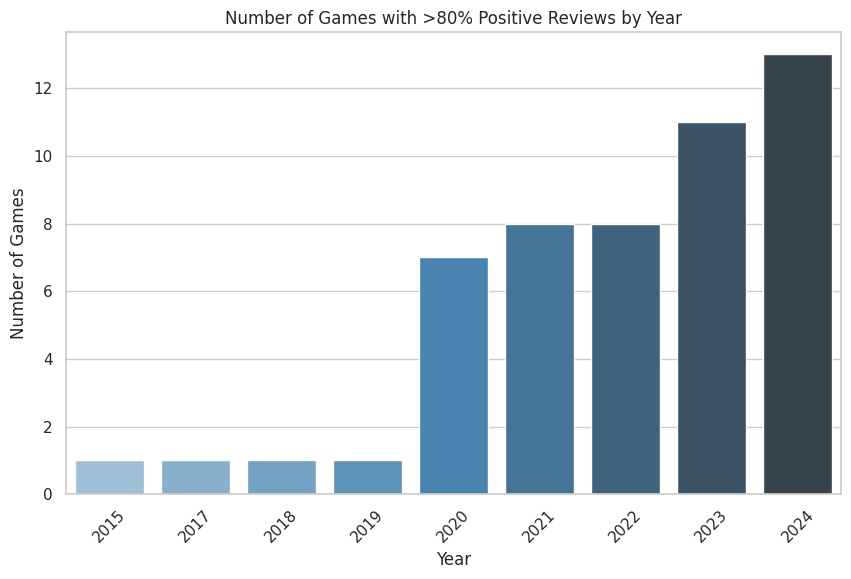

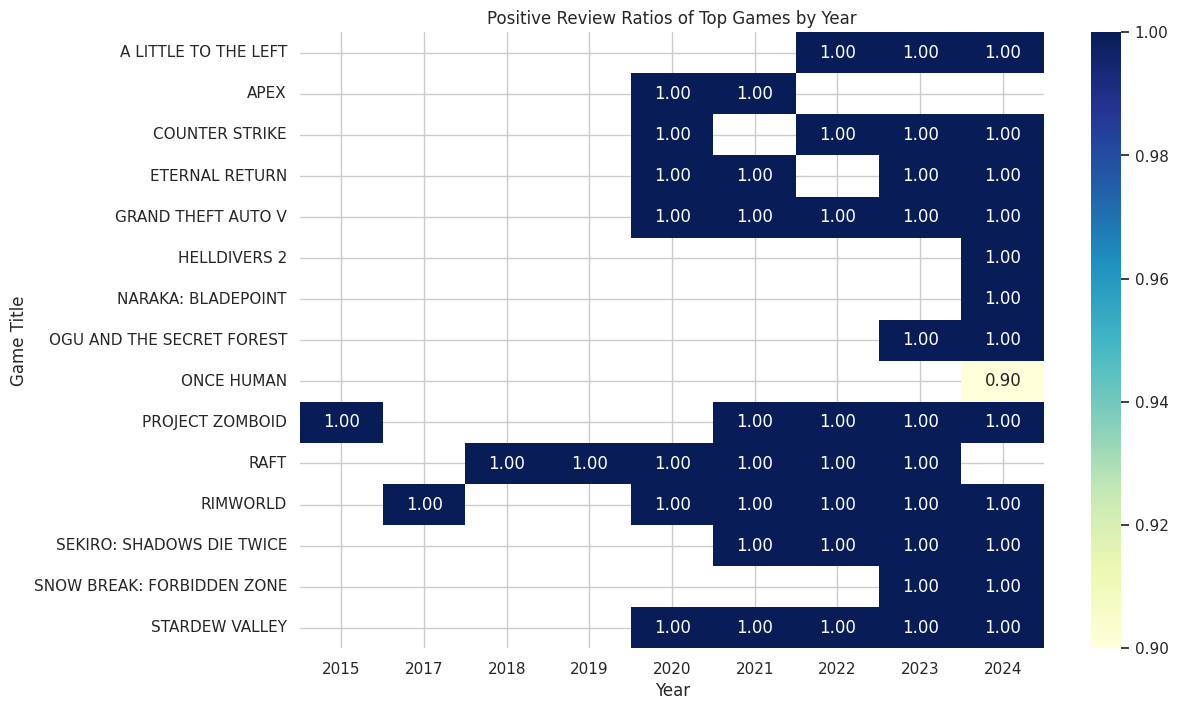

In [ ]:
import pandas as pd

reviews_df = pd.read_csv('steam_reviews.csv')

reviews_df['date_posted'] = pd.to_datetime(reviews_df['date_posted'])
reviews_df['year'] = reviews_df['date_posted'].dt.year
yearly_positive_ratios = reviews_df.groupby(['year', 'title'])['score'].mean().reset_index()
top_games_by_year = yearly_positive_ratios[yearly_positive_ratios['score'] >= 0.8]
top_games_count_by_year = top_games_by_year.groupby('year')['title'].count()

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=top_games_count_by_year.index, y=top_games_count_by_year.values, palette="Blues_d")
plt.title('Number of Games with >80% Positive Reviews by Year')
plt.xlabel('Year')
plt.ylabel('Number of Games')
plt.xticks(rotation=45)
plt.show()

pivot_data = top_games_by_year.pivot(index="title", columns="year", values="score")
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Positive Review Ratios of Top Games by Year')
plt.xlabel('Year')
plt.ylabel('Game Title')
plt.show()

이 코드는 Steam 게임 리뷰 데이터에서 연도별로 긍정적 리뷰 비율이 높은 게임을 분석하고 시각화하고 있다. 각 연도와 게임 제목별로 평균 긍정적인 리뷰 비율을 계산하고, 이 비율이 80% 이상인 게임들을 필터링하여 연도별로 긍정적 리뷰 비율이 높은 게임들을 찾을 수 있다.

또 각 게임마다 긍정적 리뷰 비율을 연도별로 비교하기 위해 히트맵을 생성했다. 이 히트맵은 각 게임 제목과 연도별 긍정적인 리뷰 비율을 색상으로 표현해, 시간이 지남에 따라 게임의 긍정적인 리뷰 비율이 어떻게 변화했는지를 한눈에 파악할 수 있었다.

            Topic  2021  2022  2023
13     characters     1     2     1
15          pitch     0     2     1
28      thrilling     2     0     1
30      adventure     3     3     3
34         living     1     1     2
..            ...   ...   ...   ...
495  hypermotion2     0     2     1
496          rise     0     2     1
512           new     3     2     5
523        engine     0     0     2
529         years     0     1     2

[86 rows x 4 columns]


<ipython-input-22-7990995779cd>:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


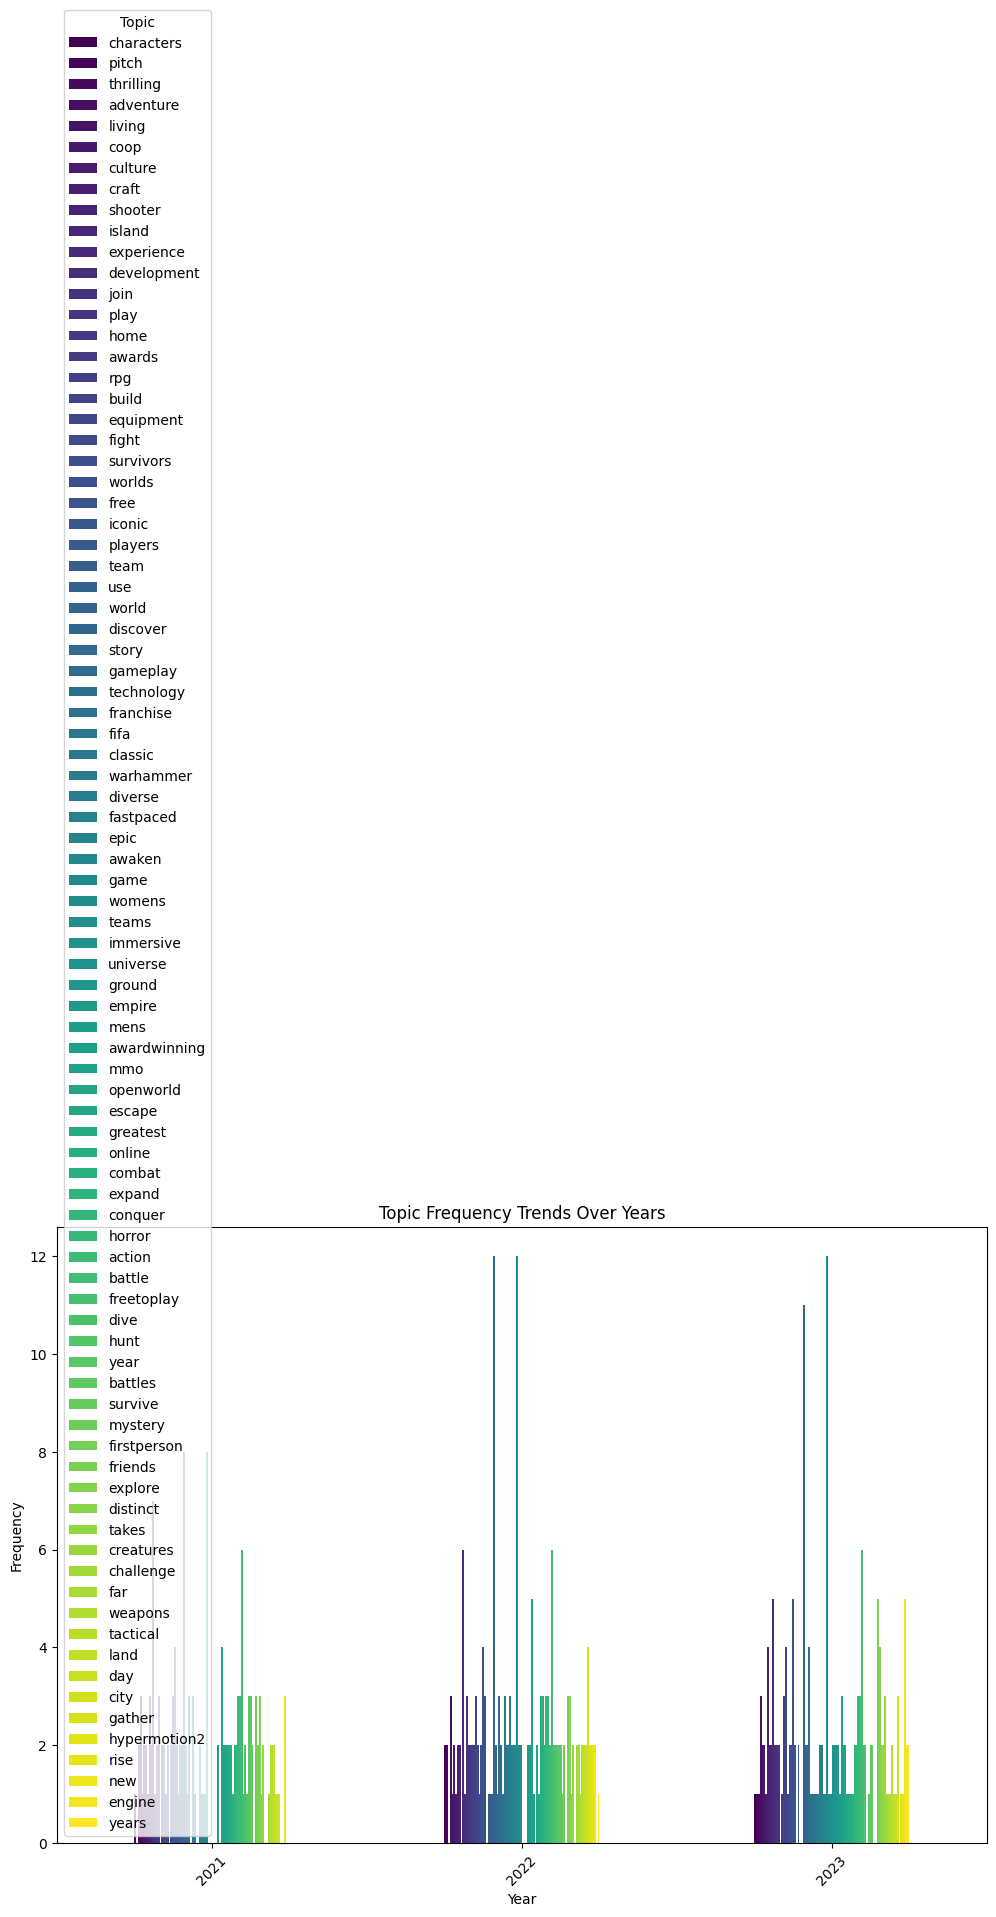

In [ ]:
import requests
from bs4 import BeautifulSoup
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# App ID lists for each year
games_2021 =  [
    '1517290', '1063730', '359550', '578080', '892970', '1085660',
    '570', '1203220', '730', '1172470', '381210', '271590',
    '230410', '1172620', '1293830', '1551360', '1174180', '1506830',
    '306130', '1426210', '236390', '252490', '924970', '440',
    '281990', '346110', '680420', '289070', '1240440', '582010',
    '1222670', '1091500', '739630', '227300', '1328670', '1196590',
    '1466860'
]

games_2022 = [
    "730", "1449850", "534380", "1203220", "1245620", "570", "1172470", "1085660",
    "1938090", "1446780", "578080", "236390", "1551360", "1593500", "1174180",
    "1142710", "1091500", "1811260", "359550", "271590", "381210", "1811260",
    "230410", "594650", "108600", "1604030", "242760", "1172620", "1361210",
    "1506830", "1222670", "1426210", "920210", "1817070", "1332010", "252490",
    "289070", "440", "739630", "281990", "1313140", "294100", "255710", "648800",
    "306130", "1644960"
]

games_2023 = [
    "1326470", "578080", "1716740", "1091500", "570", "1172470", "1938090",
    "1086940", "990080", "1085660", "730", "381210", "1174180", "2195250",
    "1888160", "271590", "1203220", "1245620", "359550", "236390", "1811260",
    "230410", "2050650", "1172620", "1919590", "1282100", "306130", "671860",
    "2399830", "108600", "1774580", "289070", "1260320", "440", "1693980",
    "1142710", "252490", "1449850", "1966720", "1551360", "281990", "227300",
    "1364780", "1063730", "1222670", "949230"
]

# Dictionary to store topic keywords by year
topics_by_year = {'2021': [], '2022': [], '2023': []}

# Function to extract topics from descriptions
def extract_topics_from_description(description):
    # Text preprocessing for topic modeling
    clean_text = re.sub(r'[^\w\s]', '', description)  # Remove punctuation

    # LDA Topic Modeling
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform([clean_text])

    lda = LatentDirichletAllocation(n_components=1, random_state=42)
    lda.fit(X)

    # Extract topics
    keywords = [vectorizer.get_feature_names_out()[i] for i in lda.components_[0].argsort()[:-10 - 1:-1]]
    return keywords

# Process each game's description
def process_game_descriptions(game_list, year):
    for app_id in game_list:
        # URL setup
        url = f'https://store.steampowered.com/app/{app_id}/'

        # Fetch webpage
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find game description snippet
        description_div = soup.find('div', class_='game_description_snippet')

        if description_div:
            game_description = description_div.get_text(strip=True)
            # Extract topics and add to the year's list
            topics = extract_topics_from_description(game_description)
            topics_by_year[year].extend(topics)

# Process descriptions for each year
process_game_descriptions(games_2021, '2021')
process_game_descriptions(games_2022, '2022')
process_game_descriptions(games_2023, '2023')

# Create DataFrame to store counts
def create_topic_counts_df(topics_by_year):
    all_topics = set()
    for topics in topics_by_year.values():
        all_topics.update(topics)

    data = {'Topic': list(all_topics)}
    for year in topics_by_year:
        data[year] = [topics_by_year[year].count(topic) for topic in all_topics]

    df = pd.DataFrame(data)
    return df

# Create DataFrame
topic_counts_df = create_topic_counts_df(topics_by_year)

# Filter out topics with count of 1 in any year
filtered_df = topic_counts_df[(topic_counts_df.iloc[:, 1:] > 1).any(axis=1)]

# Print the filtered DataFrame
print(filtered_df)

# Plot the trends
def plot_topic_trends(df):
    df.set_index('Topic').T.plot(kind='bar', figsize=(12, 8), colormap='viridis')
    plt.title('Topic Frequency Trends Over Years')
    plt.xlabel('Year')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.legend(title='Topic')
    plt.tight_layout()
    plt.show()

# Plot the topic trends
plot_topic_trends(filtered_df)


이 코드에서는 steam api를 활용해, 게임의 설명란에서 특정한 주제들을 추출하고, 이를 통해 트렌드를 파악하기 위한 분석을 하고 있다.

코드에서는 게임의 상세 정보 수집을 위해 Steam 웹사이트에서 게임 페이지를 탐색한다. 게임 페이지의 설명란은 게임의 특성이나 스토리, 게임 플레이 방식 등이 간단히 설명되어 있는데, 이를 사용해 각 게임의 콘텐츠를 분석하는 용으로 사용하기로 했다.

게임의 설명을 수집한 후, 텍스트 전처리 과정을 통해 문서에서 불필요한 기호를 제거하고 정제하였다. 이후 LDA 주제 모델링 기법을 사용해 텍스트에서 주요 주제를 추출했다. 이후 주제를 연도별로 정리하고, 이를 시각화하여 시간에 따른 변화 추이를 확인할 수 있도록 했다.

In [ ]:
# Function to analyze trends in topic counts
def analyze_trends(df):
    """
    Analyze trends in topic counts over years to identify increasing and decreasing topics.

    :param df: DataFrame containing topic counts per year.
    """
    # Calculate the trend for each topic
    trend_results = {}
    for _, row in df.iterrows():
        topic = row['Topic']
        counts = row[1:].values
        if len(counts) > 1:
            # Determine the trend by comparing the first and last values
            if counts[0] < counts[-1]:
                trend = 'increasing'
            elif counts[0] > counts[-1]:
                trend = 'decreasing'
            else:
                continue

            trend_results[topic] = trend

    # Print increasing and decreasing trends
    print("\nIncreasing Topics:")
    for topic, trend in trend_results.items():
        if trend == 'increasing':
            print(f"{topic}")

    print("\nDecreasing Topics:")
    for topic, trend in trend_results.items():
        if trend == 'decreasing':
            print(f"{topic}")

    return trend_results

# Analyze trends
analyze_trends(filtered_df)


Increasing Topics:
pitch
living
craft
development
rpg
build
fight
worlds
players
world
story
gameplay
technology
classic
warhammer
fastpaced
game
womens
teams
immersive
universe
ground
mens
freetoplay
friends
explore
distinct
creatures
challenge
city
hypermotion2
rise
new
engine
years

Decreasing Topics:
thrilling
culture
shooter
experience
play
awards
equipment
free
iconic
team
use
franchise
awardwinning
escape
greatest
online
hunt
year
battles
firstperson
weapons
land
gather


{'pitch': 'increasing',
 'thrilling': 'decreasing',
 'living': 'increasing',
 'culture': 'decreasing',
 'craft': 'increasing',
 'shooter': 'decreasing',
 'experience': 'decreasing',
 'development': 'increasing',
 'play': 'decreasing',
 'awards': 'decreasing',
 'rpg': 'increasing',
 'build': 'increasing',
 'equipment': 'decreasing',
 'fight': 'increasing',
 'worlds': 'increasing',
 'free': 'decreasing',
 'iconic': 'decreasing',
 'players': 'increasing',
 'team': 'decreasing',
 'use': 'decreasing',
 'world': 'increasing',
 'story': 'increasing',
 'gameplay': 'increasing',
 'technology': 'increasing',
 'franchise': 'decreasing',
 'classic': 'increasing',
 'warhammer': 'increasing',
 'fastpaced': 'increasing',
 'game': 'increasing',
 'womens': 'increasing',
 'teams': 'increasing',
 'immersive': 'increasing',
 'universe': 'increasing',
 'ground': 'increasing',
 'mens': 'increasing',
 'awardwinning': 'decreasing',
 'escape': 'decreasing',
 'greatest': 'decreasing',
 'online': 'decreasing',
 

이 코드는 주제의 빈도 변화 추세를 파악하고, 이를 기반으로 주제가 증가하거나 감소하는지를 식별하는 기능을 수행한다. 이를 이용해 트렌드를 파악하는 데에 사용할 수 있었다.


Increasing Topics:
pitch
living
craft
development
rpg
build
fight
worlds
players
world
story
gameplay
technology
classic
warhammer
fastpaced
game
womens
teams
immersive
universe
ground
mens
freetoplay
friends
explore
distinct
creatures
challenge
city
hypermotion2
rise
new
engine
years

Decreasing Topics:
thrilling
culture
shooter
experience
play
awards
equipment
free
iconic
team
use
franchise
awardwinning
escape
greatest
online
hunt
year
battles
firstperson
weapons
land
gather


<Figure size 1400x800 with 0 Axes>

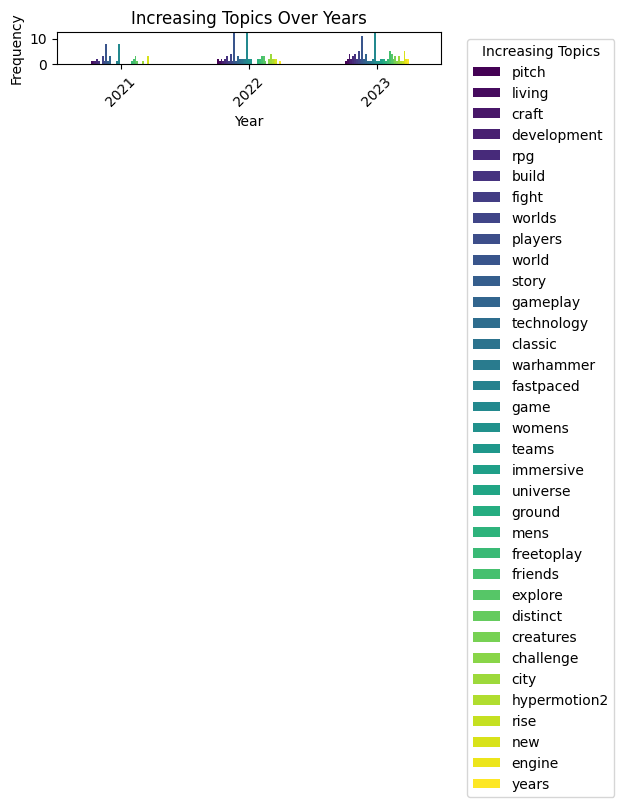

<Figure size 1400x800 with 0 Axes>

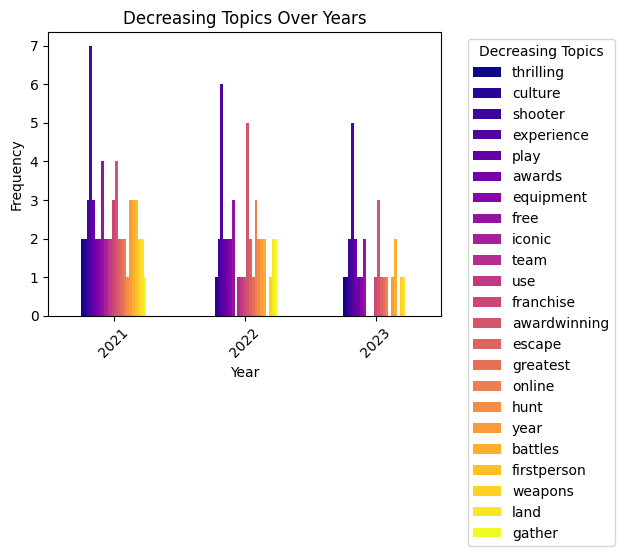

In [ ]:
import matplotlib.pyplot as plt

# Function to plot increasing and decreasing topic trends
def plot_trends(trend_results, df):
    """
    Plot increasing and decreasing topic trends with topics clustered together.

    :param trend_results: Dictionary with topics and their trend (increasing or decreasing).
    :param df: DataFrame containing topic counts per year.
    """
    # Separate increasing and decreasing topics
    increasing_topics = [topic for topic, trend in trend_results.items() if trend == 'increasing']
    decreasing_topics = [topic for topic, trend in trend_results.items() if trend == 'decreasing']

    # Get data for increasing topics
    increasing_counts = df[df['Topic'].isin(increasing_topics)].set_index('Topic').T
    # Get data for decreasing topics
    decreasing_counts = df[df['Topic'].isin(decreasing_topics)].set_index('Topic').T

    # Plot increasing topics
    plt.figure(figsize=(14, 8))
    increasing_counts.plot(kind='bar', colormap='viridis', title='Increasing Topics Over Years')
    plt.xlabel('Year')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.legend(title='Increasing Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('increasing_topics_clustered.png')
    plt.show()

    # Plot decreasing topics
    plt.figure(figsize=(14, 8))
    decreasing_counts.plot(kind='bar', colormap='plasma', title='Decreasing Topics Over Years')
    plt.xlabel('Year')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.legend(title='Decreasing Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('decreasing_topics_clustered.png')
    plt.show()

# Analyze trends
trend_results = analyze_trends(filtered_df)

# Plot the trends
plot_trends(trend_results, filtered_df)


마지막으로 증가하는 추세인 topic과 감소하는 추세인 topic을 시각화 해보았다.